# Metabolon pilot Human Metabolite Disease Network

In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from scipy import stats
from statsmodels.stats.multitest import multipletests
import networkx as nx

c:\Users\cw2019\.conda\envs\py10\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\cw2019\.conda\envs\py10\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\cw2019\.conda\envs\py10\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Processing datasets

In [2]:

class MetabolonDataset:
    '''
    Class to load and QC metabolon data
    '''
    def __init__(self, file_path, id, node_name, first_row_index, first_col_index, identifiers_row, md_sampname, md_group, md_filter):
        self.file_path = file_path
        self.raw_data = None
        self.compound_mappers = None
        self.processed_data = None
        self.metadata = None
        self.id = id
        self.node_name = node_name
        self.first_row_index = first_row_index
        self.first_col_index = first_col_index
        self.identifiers_row = identifiers_row
        self.md_sampname = md_sampname
        self.md_group = md_group
        self.md_filter = md_filter
        self.DA_metabolites = None

        self.read_data(file_path)
        self.preprocess_data()
        self.da_testing()
        
    def read_data(self, file_path):
        """
        Read in the metabolon data
        """
        # read in the data
        data = pd.read_excel(file_path + '/peaktable.xlsx', header=None)
        self.raw_data = data

        metadata = pd.read_csv(file_path + '/s_' + self.id + '.txt', sep = '\t')

        self.metadata = metadata
        self.metadata[self.md_sampname] = self.metadata[self.md_sampname].astype(str)
        print(metadata[[self.md_sampname, self.md_group]].head())

        return data, metadata

    def preprocess_data(self):
        data_filt = self.raw_data.copy()
        data_filt.index = data_filt.iloc[:, 0]
        data_filt.columns = data_filt.iloc[self.identifiers_row, :].astype(str)
        data_filt = data_filt.iloc[self.first_row_index:, self.first_col_index:]

        # ensure all data is numeric
        data_filt = data_filt.apply(pd.to_numeric, errors='coerce')

        # Transpose
        data_filt = data_filt.T

        # Missingness checks 
        # replace empty strings with NaN
        data_filt = data_filt.replace(['', ' '], np.nan)
        # Delete colums and rows where all values are missing
        data_filt = data_filt.dropna(axis=0, how='all')
        data_filt = data_filt.dropna(axis=1, how='all')

        data_filt = data_filt.dropna(axis=1, thresh=0.3*data_filt.shape[0])
        missing_pct = data_filt.isnull().sum().sum() / (data_filt.shape[0] * data_filt.shape[1]) * 100
        print(f"Missingness: {missing_pct:.2f}%")

        # impute missing values
        imputer = KNNImputer(n_neighbors=2, weights="uniform").set_output(transform="pandas")
        data_imputed = imputer.fit_transform(data_filt)

        # log transformation
        data_imputed = np.log(data_imputed + 1)

        # standardize
        scaler = StandardScaler().set_output(transform="pandas")
        data_scaled = scaler.fit_transform(data_imputed)

        # add metadata column
        md_dict = dict(zip(self.metadata[self.md_sampname], self.metadata[self.md_group]))
        data_scaled['Group'] = data_scaled.index.map(md_dict)


        # filter on metadata
        # TODO check whether to rescale after filtering
        data_scaled = data_scaled[data_scaled['Group'].isin(self.md_filter)]

        self.processed_data = data_scaled

        return data_scaled
    
    def plot_qc(self):
        
        # PCA biplot
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(self.processed_data.iloc[:, :-1])

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        sns.scatterplot(
            x=pca_result[:, 0], y=pca_result[:, 1],
            hue="Group",
            data=self.processed_data,
            alpha=0.7,
            ax=ax1
        )

        # normality every nth feature
        normaliser = (self.processed_data.shape[1] - 1) / 20
        sns.boxplot(data=self.processed_data.iloc[:, ::50], ax=ax2)
        plt.show()

    def da_testing(self):

        # t-test for two groups
        groups = self.processed_data['Group'].unique()
        stat, pvals = stats.ttest_ind(self.processed_data[self.processed_data['Group'] == groups[0]].iloc[:, :-1],
                        self.processed_data[self.processed_data['Group'] == groups[1]].iloc[:, :-1],
                        alternative='two-sided')
        pval_df = pd.DataFrame(pvals, index=self.processed_data.columns[:-1], columns=['P-value'])

        # fdr correction 
        pval_df['FDR_P-value'] = multipletests(pvals, method='fdr_bh')[1]

        # return significant metabolites
        self.DA_metabolites = pval_df[pval_df['FDR_P-value'] < 0.05].index.tolist()
        print(f"Number of differentially abundant metabolites: {len(self.DA_metabolites)}") 

        # generate tuples for nx links
        self.connection = [(self.node_name, met) for met in self.DA_metabolites]
    


In [140]:
pkm2_data = MetabolonDataset(
    file_path = 'MTBLS533',
    id = 'MTBLS533',
    node_name = 'PKM2 knockout cell line',
    first_row_index = 3,
    first_col_index = 6,
    identifiers_row = 1,
    md_sampname = 'Sample Name',
    md_group = 'Factor Value[Genotype]',
    md_filter = ['WT', 'PKM2 KO']
)

  Sample Name Factor Value[Genotype]
0  UWIM-00278                     WT
1  UWIM-00279                     WT
2  UWIM-00280                     WT
3  UWIM-00281                     WT
4  UWIM-00282                PKM2 KO
Missingness: 7.79%


IndexError: index 0 is out of bounds for axis 0 with size 0

In [136]:
erbc_data = MetabolonDataset(
    file_path = 'MTBLS3342', 
    id = 'MTBLS3342', 
    node_name = 'estrogen receptor positive breast cancers', 
    first_row_index = 5, 
    first_col_index = 6, 
    identifiers_row=0,
    md_sampname='Sample Name',
    md_group = 'Factor Value[IACS Response]',
    md_filter=['responder', 'resistant'])

KeyError: "['Factor Value[IACS Response]'] not in index"

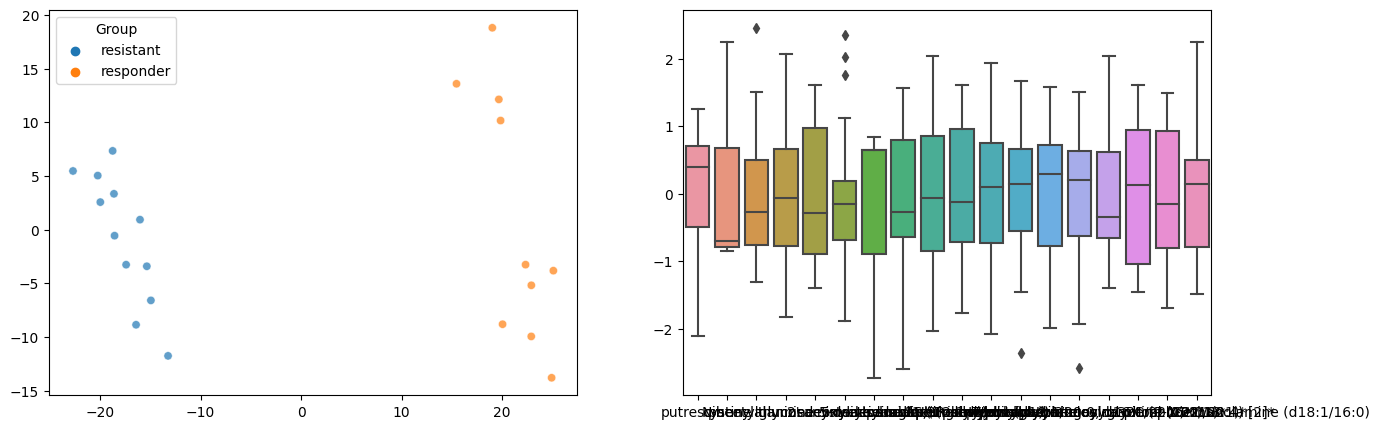

In [61]:
erbc_data.plot_qc()

In [4]:

pmh_data = MetabolonDataset(
    file_path = 'MTBLS136', 
    id = 'MTBLS136', 
    node_name = 'Post-menopausal hormone use', 
    first_row_index=4, 
    first_col_index=9, 
    identifiers_row=1,
    md_sampname='Sample Name',
    md_group='Factor Value[CurrentPMH]',
    md_filter=['Nonuser', 'E-only']
    )


  Sample Name Factor Value[CurrentPMH]
0   063459_01                  Nonuser
1   081531_03                   E-only
2  022817_136                      NaN
3   079243_03                  Nonuser
4   034993_02                   E-only
Missingness: 10.17%
Number of differentially abundant metabolites: 612


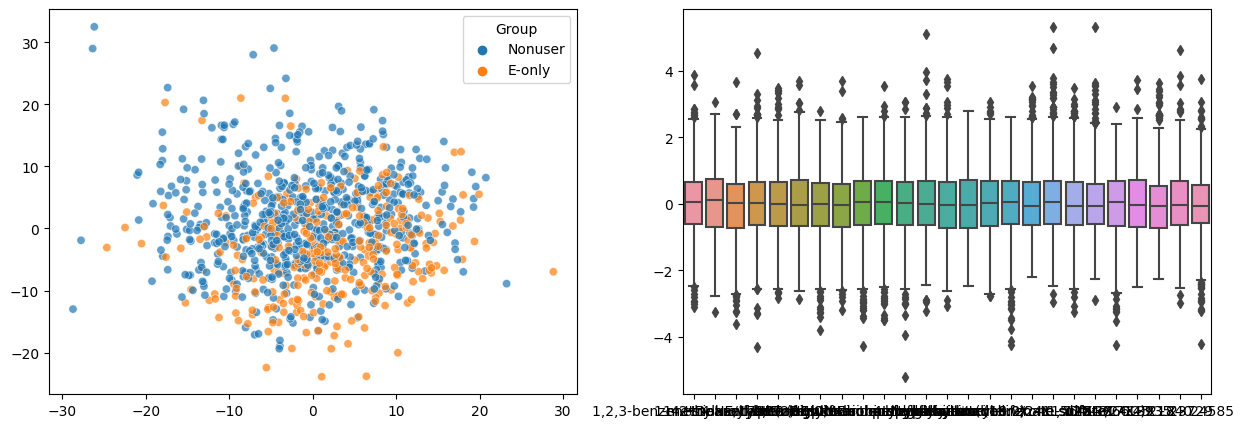

In [75]:
pmh_data.plot_qc()

In [21]:
preterm_data = MetabolonDataset(
    file_path = 'MTBLS702',
    id = 'MTBLS702',
    node_name = 'Preterm birth (race)',
    first_row_index=2,
    first_col_index=6,
    identifiers_row=1,
    md_sampname='Sample Name',
    md_group='Factor Value[Race]',
    md_filter=['Black', 'White']
    )


  Sample Name Factor Value[Race]
0  UNPA-02736              Black
1  UNPA-02740              Black
2  UNPA-02745              Black
3  UNPA-02749              Black
4  UNPA-02750              Black
Missingness: 22.13%
Number of differentially abundant metabolites: 22


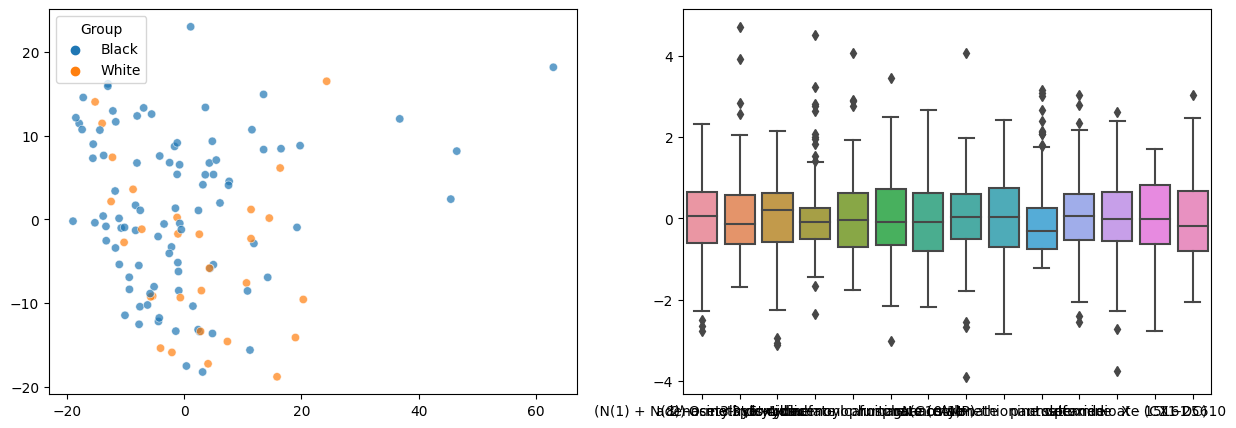

In [11]:
preterm_data.plot_qc()

In [22]:

sct_data = MetabolonDataset(
    file_path = 'MTBLS406', 
    id = 'MTBLS406', 
    node_name = 'Stem cell transplant (gender)', 
    first_row_index = 3, 
    first_col_index = 6, 
    identifiers_row=1,
    md_sampname='Source Name',
    md_group = 'Factor Value[Gender]',
    md_filter=['Male', 'Female']
    )

      Source Name Factor Value[Gender]
0  BG111_24_02_14                 Male
1  ME114_24_02_14               Female
2  GD112_25_02_14                 Male
3  BG111_10_03_14                 Male
4  ME114_10_03_14               Female
Missingness: 8.37%
Number of differentially abundant metabolites: 213


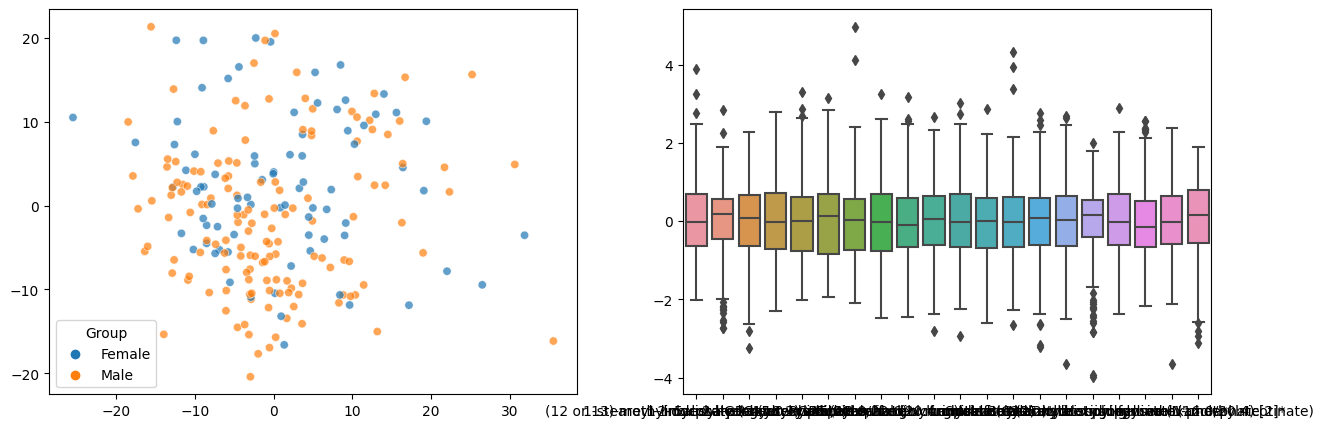

In [14]:
sct_data.plot_qc()

In [5]:
# all_data = MetabolonDataset(
#     file_path = 'MTBLS2394', 
#     id = 'MTBLS2394', 
#     node_name = 'Acute lymphoblastic leukemia', 
#     first_row_index = 2, 
#     first_col_index = 7, 
#     identifiers_row=1,
#     md_sampname='Source Name',
#     md_group = 'Factor Value[Time Point]',
#     md_filter=['inital time point', 'post time point']
#     )

     Source Name Factor Value[Time Point]
0            P01       initial time point
1            P02       initial time point
2            P04       initial time point
3            P05       initial time point
4            P06       initial time point
..           ...                      ...
103  unassigned4                      NaN
104  unassigned5                      NaN
105  unassigned6                      NaN
106  unassigned7                      NaN
107  unassigned8                      NaN

[108 rows x 2 columns]


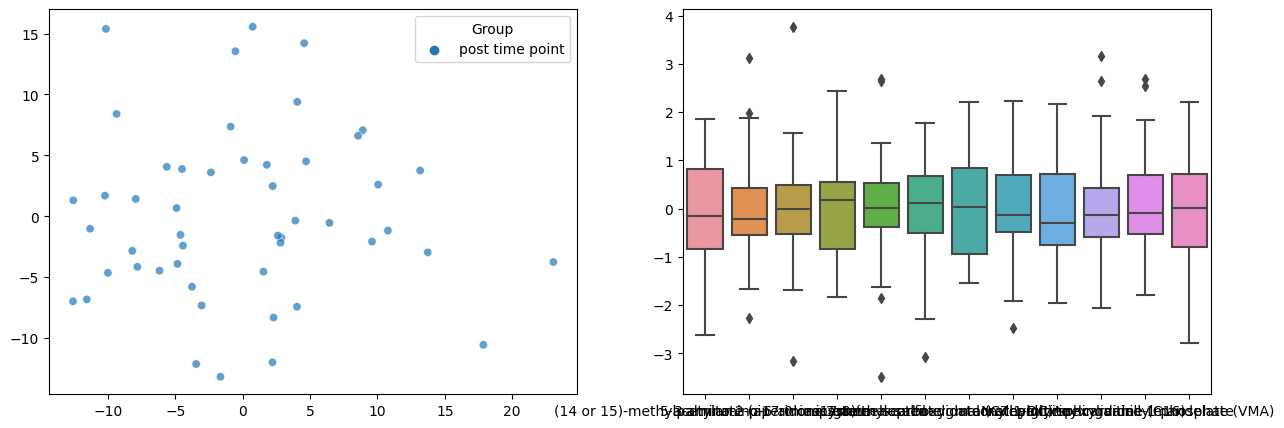

In [7]:
all_data.plot_qc()

## HMDN - bipartite graph

In [23]:
from networkx.algorithms import bipartite
B = nx.Graph()
# Add nodes with the node attribute "bipartite"-
B.add_nodes_from([sct_data.node_name, pmh_data.node_name, preterm_data.node_name, erbc_data.node_name], bipartite=0)
B.add_nodes_from(sct_data.DA_metabolites + pmh_data.DA_metabolites + preterm_data.DA_metabolites + erbc_data.DA_metabolites, bipartite=1)
# Add edges only between nodes of opposite node sets
B.add_edges_from(sct_data.connection + pmh_data.connection + preterm_data.connection + erbc_data.connection)

In [24]:
bottom_nodes, top_nodes = bipartite.sets(B)

In [25]:
nx.is_connected(B)

True

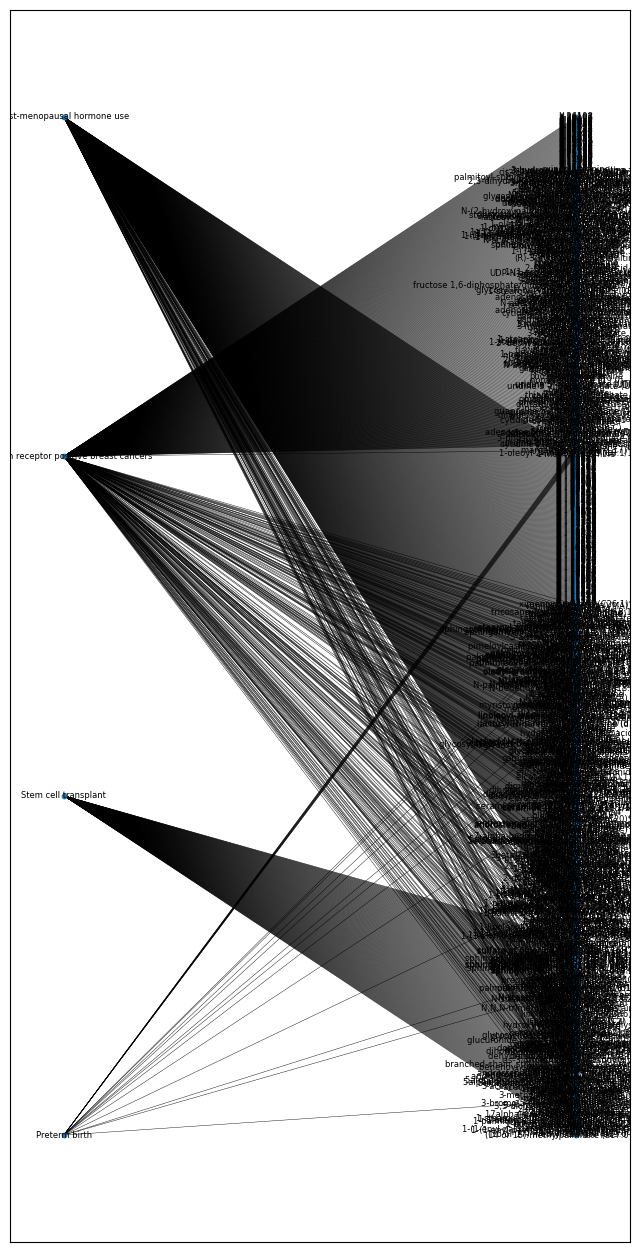

In [18]:
plt.figure(3,figsize=(8,16)) 
nx.draw_networkx(
    B,
    pos = nx.drawing.layout.bipartite_layout(B, bottom_nodes),
    font_size=6,
    width = 0.3,
    with_labels=True,
    node_size=10,
    ) # Or whatever other display options you like

plt.show()

In [94]:
bottom_nodes

{'Post-menopausal hormone use',
 'Preterm birth (race)',
 'Stem cell transplant (gender)',
 'estrogen receptor positive breast cancers'}

Stem cell transplant (gender)
Post-menopausal hormone use
Preterm birth (race)
estrogen receptor positive breast cancers


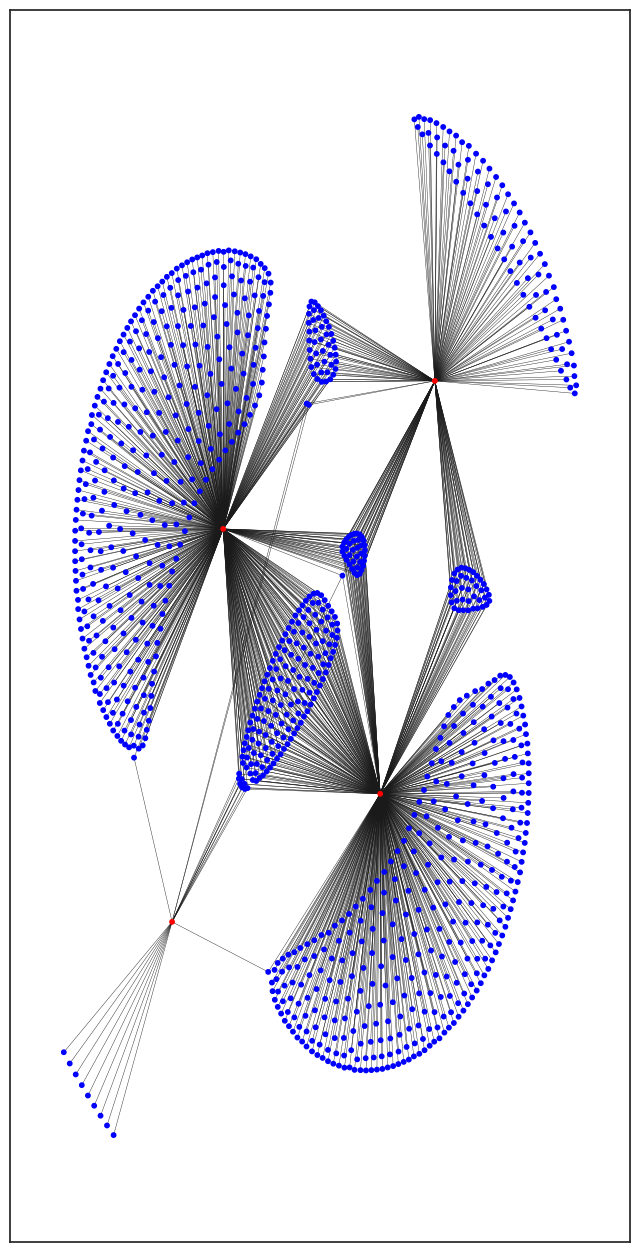

In [96]:

# force directed layout
color_map = []
for node in B:
    if node in bottom_nodes:
        print(node)
        color_map.append('red')
    else: 
        color_map.append('blue')      

plt.figure(3,figsize=(8,16)) 
nx.draw_networkx(
    B,
    pos = nx.drawing.layout.kamada_kawai_layout(B),
    font_size=6,
    width = 0.3,
    with_labels=False,
    node_size=10,
    node_color=color_map
    ) # Or whatever other display options you like


plt.show()

In [86]:
# export gml for cytoscape
nx.write_graphml_lxml(B, "metabolon_HMDN.graphml")

### HDN - disease-disease network
- Nodes are connected if they share common metabolites
- The weight of the edge is the number of common metabolites

In [26]:
biadj_mat = nx.bipartite.biadjacency_matrix(B, row_order=bottom_nodes, column_order=top_nodes).toarray()

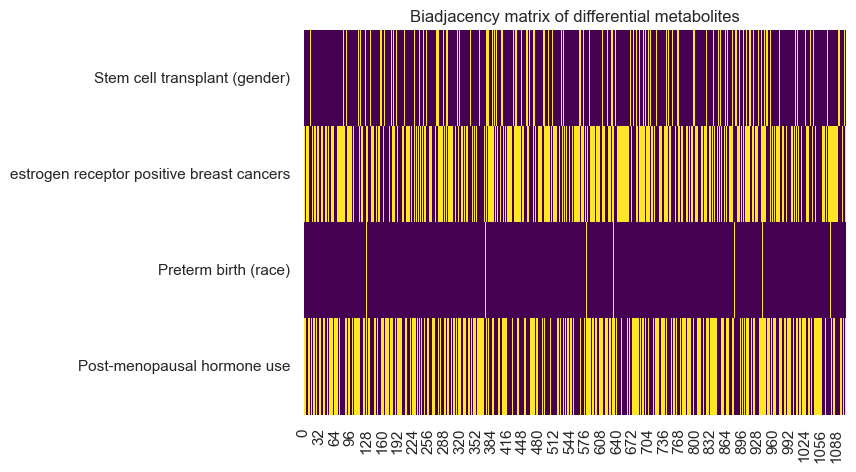

In [27]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(biadj_mat, cmap='viridis', cbar=False)
ax.set_yticklabels(bottom_nodes, rotation=0)
ax.set_title('Biadjacency matrix of differential metabolites')
plt.show()

In [28]:
# create adjacency matrix based on the number of shared metabolites
# this can be done by multiplying the biadjacency matrix by its transpose
adj_mat = pd.DataFrame(biadj_mat @ biadj_mat.T, index=list(bottom_nodes), columns=list(bottom_nodes))


In [29]:
adj_mat

,Stem cell transplant (gender),estrogen receptor positive breast cancers,Preterm birth (race),Post-menopausal hormone use
Stem cell transplant (gender),213,77,3,84
estrogen receptor positive breast cancers,77,596,10,198
Preterm birth (race),3,10,22,12
Post-menopausal hormone use,84,198,12,612


In [82]:
len(set(sct_data.DA_metabolites) & set(pmh_data.DA_metabolites))

84

c:\Users\cw2019\.conda\envs\py10\lib\site-packages\seaborn\matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


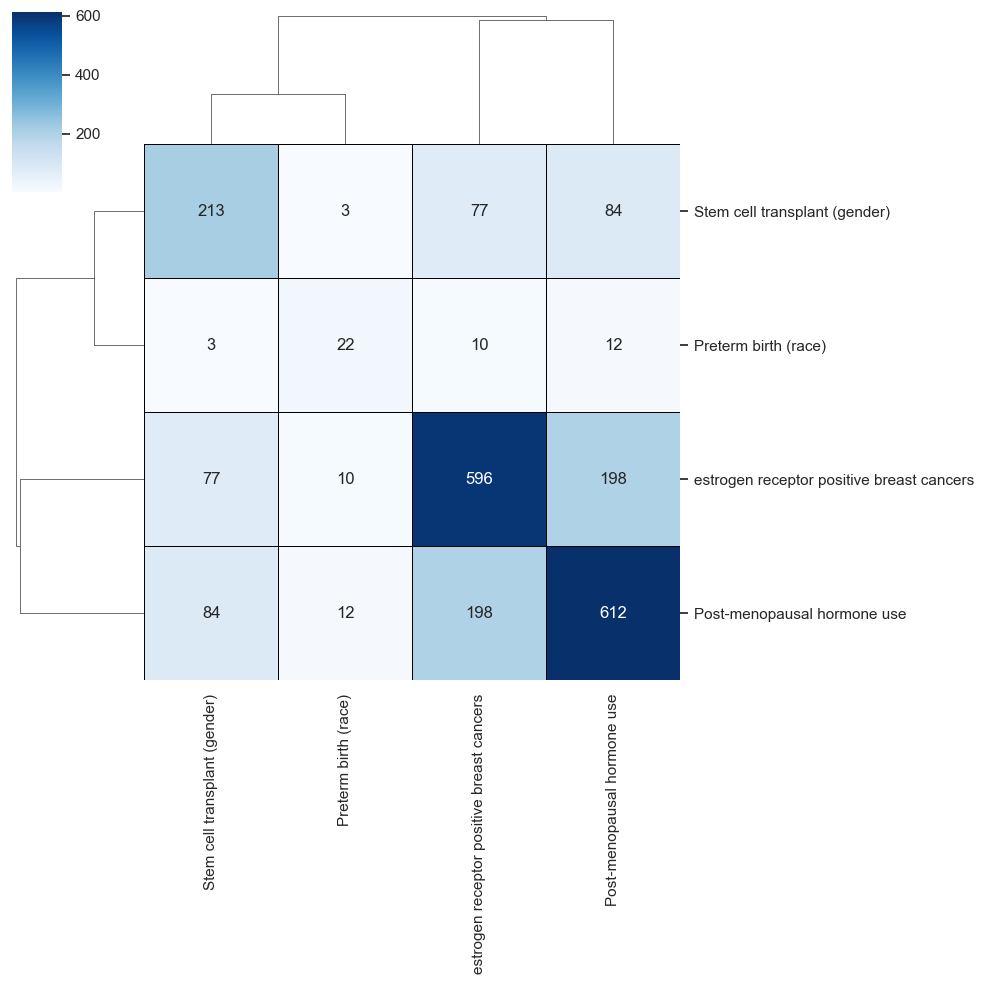

In [32]:
# fig, ax = plt.subplots(figsize=(7, 5))
sns.set(style='white')
sns.clustermap(
    adj_mat, 
    cmap='Blues', 
    square=True, 
    annot=True, 
    # cbar=False, 
    fmt='d', 
    linewidths=0.5, 
    linecolor='black' )
# ax.set_yticklabels(bottom_nodes, rotation=0)
# ax.set_xticklabels(bottom_nodes, rotation=90)
ax.set_title('Similarity matrix of differential metabolites')
# plt.tight_layout()
plt.show()


In [33]:
# make pandas edgelist
edgelist = adj_mat.stack().reset_index()
edgelist.columns = ['source', 'target', 'weight']



In [104]:
edgelist

,source,target,weight
0,Stem cell transplant,Stem cell transplant,213
1,Stem cell transplant,estrogen receptor positive breast cancers,77
2,Stem cell transplant,Post-menopausal hormone use,84
3,Stem cell transplant,Preterm birth,3
4,estrogen receptor positive breast cancers,Stem cell transplant,77
5,estrogen receptor positive breast cancers,estrogen receptor positive breast cancers,596
6,estrogen receptor positive breast cancers,Post-menopausal hormone use,198
7,estrogen receptor positive breast cancers,Preterm birth,10
8,Post-menopausal hormone use,Stem cell transplant,84
9,Post-menopausal hormone use,estrogen receptor positive breast cancers,198


In [34]:
hdn_graph = nx.from_pandas_edgelist(edgelist, edge_attr='weight')
hdn_graph.remove_edges_from(nx.selfloop_edges(hdn_graph))

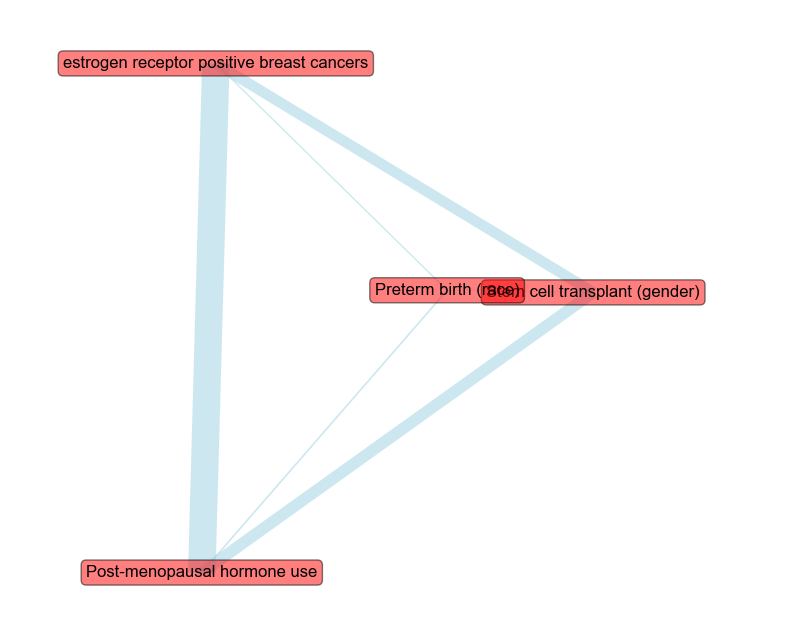

In [35]:

widths = nx.get_edge_attributes(hdn_graph, 'weight')
nodelist = hdn_graph.nodes()

plt.figure(figsize=(10,8))

pos = nx.kamada_kawai_layout(hdn_graph)
nx.draw_networkx_nodes(hdn_graph,pos,
                       nodelist=nodelist,
                       node_size=0,
                       node_color='white',
                       alpha=0.7)
nx.draw_networkx_edges(hdn_graph,pos,
                       edgelist = widths.keys(),
                       width=[i/10 for i in list(widths.values())],
                       edge_color='lightblue',
                       alpha=0.6)
nx.draw_networkx_labels(hdn_graph, pos=pos,
                        labels=dict(zip(nodelist,nodelist)),
                        bbox = dict(facecolor = "red", alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'),
                        font_color='black')
plt.box(False)
plt.margins(x=0.4)
plt.savefig('../Figures/metabolon_HDN.png', dpi=300, bbox_inches='tight')
plt.show()

## DMN - disease-metabolite network
- Nodes (metabolites) are connected if they share the same disease

In [36]:
# create adjacency matrix based on the number of shared metabolites
# this can be done by multiplying the biadjacency matrix by its transpose
adj_mat_dmn = pd.DataFrame(biadj_mat.T @ biadj_mat, index=list(top_nodes), columns=list(top_nodes))


In [53]:
'behenoyl dihydrosphingomyelin (d18:0/22:0)*' in pmh_data.DA_metabolites

True

In [37]:
adj_mat_dmn

,pyroglutamine*,palmitoyl-linoleoyl-glycerol (16:0/18:2) [2]*,O-sulfo-L-tyrosine,N-acetylcitrulline,X - 22834,N-(2-hydroxypalmitoyl)-sphingosine (d18:1/16:0(2OH)),N-stearoyl-sphingosine (d18:1/18:0)*,eicosenoate (20:1),creatine phosphate,arachidoylcarnitine (C20)*,...,X - 23291,hexanoylglycine,ascorbate (Vitamin C),theobromine,7-hydroxyindole sulfate,2-stearoyl-GPE (18:0)*,"sphingomyelin (d18:2/24:1, d18:1/24:2)*",octadecanedioate,7-alpha-hydroxy-3-oxo-4-cholestenoate (7-Hoca),cis-4-decenoylcarnitine (C10:1)
pyroglutamine*,2,1,1,1,1,0,2,1,0,1,...,1,1,0,0,1,1,1,1,1,1
palmitoyl-linoleoyl-glycerol (16:0/18:2) [2]*,1,2,2,1,1,1,2,2,1,2,...,1,1,1,0,1,1,0,1,2,2
O-sulfo-L-tyrosine,1,2,2,1,1,1,2,2,1,2,...,1,1,1,0,1,1,0,1,2,2
N-acetylcitrulline,1,1,1,1,1,0,1,1,0,1,...,1,1,0,0,1,1,0,1,1,1
X - 22834,1,1,1,1,1,0,1,1,0,1,...,1,1,0,0,1,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2-stearoyl-GPE (18:0)*,1,1,1,1,1,0,1,1,0,1,...,1,1,0,0,1,1,0,1,1,1
"sphingomyelin (d18:2/24:1, d18:1/24:2)*",1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
octadecanedioate,1,1,1,1,1,0,1,1,0,1,...,1,1,0,0,1,1,0,1,1,1
7-alpha-hydroxy-3-oxo-4-cholestenoate (7-Hoca),1,2,2,1,1,1,2,2,1,2,...,1,1,1,0,1,1,0,1,2,2


In [81]:
# make pandas edgelist
edgelist_dmn = adj_mat_dmn.stack().reset_index()
edgelist_dmn.columns = ['source', 'target', 'weight']
edgelist_dmn = edgelist_dmn[edgelist_dmn['weight'] > 1]

In [82]:
dmn_graph = nx.from_pandas_edgelist(edgelist_dmn, edge_attr='weight')
dmn_graph.remove_edges_from(nx.selfloop_edges(dmn_graph))
nx.set_node_attributes(dmn_graph, dict(dmn_graph.degree()), 'degree')

In [83]:
nx.density(dmn_graph)

0.6064986409686187

<AxesSubplot:ylabel='Count'>

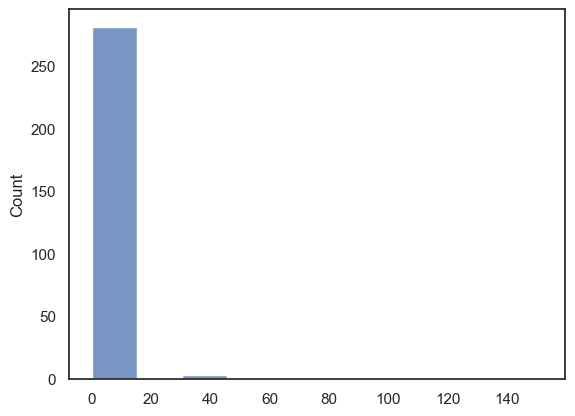

In [84]:
sns.histplot(nx.degree_histogram(dmn_graph))

In [85]:
print(dmn_graph.number_of_nodes())
print(dmn_graph.number_of_edges())

285
24545


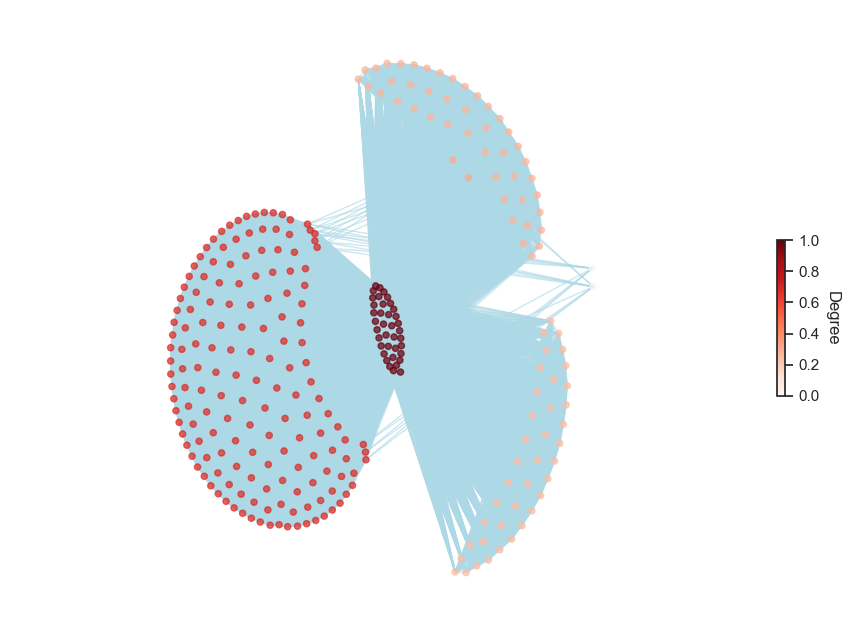

In [86]:

widths = nx.get_edge_attributes(dmn_graph, 'weight')
nodelist = dmn_graph.nodes()

plt.figure(figsize=(10,8))

pos = nx.kamada_kawai_layout(dmn_graph)
nds = nx.draw_networkx_nodes(dmn_graph,pos,
                       nodelist=nodelist,
                       node_size=20,
                       node_color=list(nx.get_node_attributes(dmn_graph, 'degree').values()),
                       cmap='Reds',
                       alpha=0.7)
nx.draw_networkx_edges(dmn_graph,pos,
                       edgelist = widths.keys(),
                    #    width=[i/10 for i in list(widths.values())],
                       edge_color='lightblue',
                       alpha=0.6)
# nx.draw_networkx_labels(dmn_graph, pos=pos,
#                         labels=dict(zip(nodelist,nodelist)),
#                         # bbox = dict(facecolor = "red", alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'),
#                         font_size=8, 
#                         font_color='black')
plt.box(False)
plt.margins(x=0.3)

cmap = plt.cm.Reds

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, orientation='vertical', fraction=0.01, pad=0.03)
cbar.ax.set_ylabel('Degree', rotation=-90, va="bottom")
# plt.savefig('../Figures/metabolon_HDN.png', dpi=300, bbox_inches='tight')
plt.show()

## Metabolite-metabolite correlation network
- Spearman correlation between metabolites per dataset
- Average correlation across datasets

In [121]:
def met_corr(datasets):

    # filter by same columns
    common_cols = set.intersection(*[set(d.processed_data.columns) for d in datasets])
    dsets_filt = [d.processed_data.loc[:, common_cols] for d in datasets]

    # calculate spearman correlation
    corrs = [d.iloc[:, :-1].corr(method='spearman').abs() for d in dsets_filt]

    # average correlation
    avg_corr = sum(corrs) / len(corrs)

    return avg_corr
# filter for same columns



In [122]:
avg_corr_mets = met_corr([sct_data, pmh_data, preterm_data, erbc_data])

C:\Users\cw2019\AppData\Local\Temp\ipykernel_32280\284953872.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dsets_filt = [d.processed_data.loc[:, common_cols] for d in datasets]
C:\Users\cw2019\AppData\Local\Temp\ipykernel_32280\284953872.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dsets_filt = [d.processed_data.loc[:, common_cols] for d in datasets]
C:\Users\cw2019\AppData\Local\Temp\ipykernel_32280\284953872.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dsets_filt = [d.processed_data.loc[:, common_cols] for d in datasets]
C:\Users\cw2019\AppData\Local\Temp\ipykernel_32280\284953872.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dsets_filt = [d.processed_data.loc[:, common_cols] for d in da

In [123]:
avg_corr_mets

,N-acetylcitrulline,O-sulfo-L-tyrosine,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPE (P-16:0/20:4)*,"1,2,3-benzenetriol sulfate (2)",propionylcarnitine (C3),N1-Methyl-2-pyridone-5-carboxamide,laurylcarnitine (C12),sarcosine,methionine sulfoxide,3-hydroxy-3-methylglutarate,...,urate,alanine,myristoleoylcarnitine (C14:1)*,gamma-glutamylglutamate,pseudouridine,glycerophosphoethanolamine,5-methylthioadenosine (MTA),quinolinate,"sphingomyelin (d18:2/24:1, d18:1/24:2)*",nicotinamide
N-acetylcitrulline,1.000000,0.256671,0.103108,0.088602,0.162893,0.214622,0.123258,0.209561,0.086992,0.237600,...,0.201514,0.084558,0.116734,0.090002,0.292208,0.106592,0.172048,0.212687,0.071998,0.087443
O-sulfo-L-tyrosine,0.256671,1.000000,0.231589,0.103507,0.256262,0.277018,0.294119,0.162880,0.074374,0.493736,...,0.377171,0.120569,0.292850,0.231200,0.452418,0.212521,0.368269,0.490625,0.149651,0.201751
1-(1-enyl-palmitoyl)-2-arachidonoyl-GPE (P-16:0/20:4)*,0.103108,0.231589,1.000000,0.185994,0.311866,0.090047,0.283259,0.285108,0.167763,0.281737,...,0.224639,0.263832,0.272652,0.238577,0.166525,0.428419,0.249478,0.278206,0.226213,0.255044
"1,2,3-benzenetriol sulfate (2)",0.088602,0.103507,0.185994,1.000000,0.094802,0.175591,0.104635,0.111538,0.167487,0.179182,...,0.279107,0.142604,0.118787,0.069074,0.174213,0.128136,0.088494,0.184457,0.130282,0.053039
propionylcarnitine (C3),0.162893,0.256262,0.311866,0.094802,1.000000,0.157652,0.271695,0.305403,0.382365,0.285851,...,0.202737,0.384672,0.274807,0.313328,0.183713,0.390802,0.402135,0.307943,0.185397,0.246603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
glycerophosphoethanolamine,0.106592,0.212521,0.428419,0.128136,0.390802,0.109303,0.344282,0.236816,0.313312,0.219908,...,0.140213,0.400110,0.358117,0.355502,0.169228,1.000000,0.383746,0.218099,0.248896,0.201723
5-methylthioadenosine (MTA),0.172048,0.368269,0.249478,0.088494,0.402135,0.148207,0.251974,0.315331,0.149806,0.408188,...,0.213995,0.312126,0.240820,0.271780,0.302556,0.383746,1.000000,0.391509,0.182537,0.342674
quinolinate,0.212687,0.490625,0.278206,0.184457,0.307943,0.342089,0.229317,0.231443,0.190989,0.441476,...,0.309526,0.295799,0.246698,0.220223,0.477277,0.218099,0.391509,1.000000,0.139927,0.270681
"sphingomyelin (d18:2/24:1, d18:1/24:2)*",0.071998,0.149651,0.226213,0.130282,0.185397,0.035968,0.238010,0.090048,0.137972,0.062451,...,0.106356,0.149109,0.190687,0.097846,0.094274,0.248896,0.182537,0.139927,1.000000,0.206343


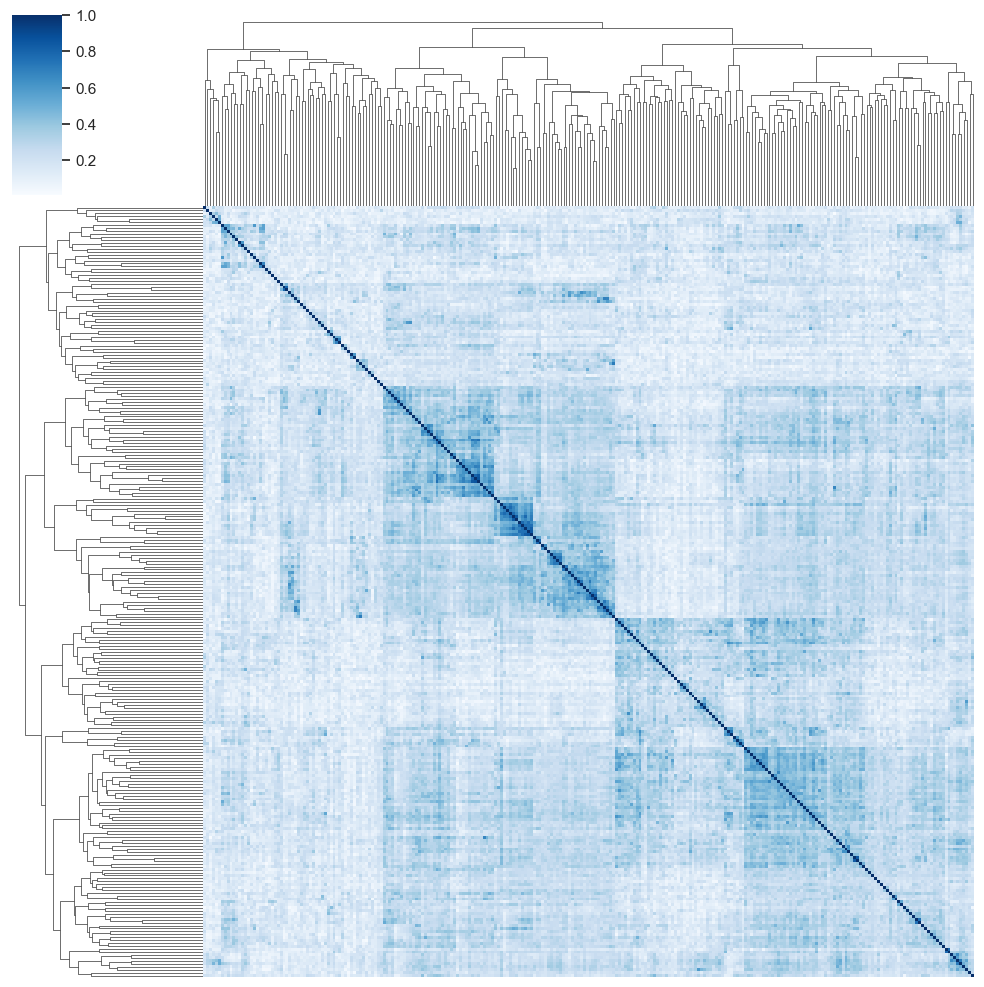

In [127]:
sns.clustermap(
    avg_corr_mets, 
    cmap='Blues', 
    square=True, 
    yticklabels=False,
    xticklabels=False,
    metric='euclidean',
    # cbar=False, 
    
    linecolor='black' )

In [130]:
# network 

edgelist_corr = avg_corr_mets.stack().reset_index()
edgelist_corr.columns = ['source', 'target', 'weight']

# filter edges
edgelist_corr = edgelist_corr[edgelist_corr['weight'] > 0.5]

corr_graph = nx.from_pandas_edgelist(edgelist_corr, edge_attr='weight')
corr_graph.remove_edges_from(nx.selfloop_edges(corr_graph))


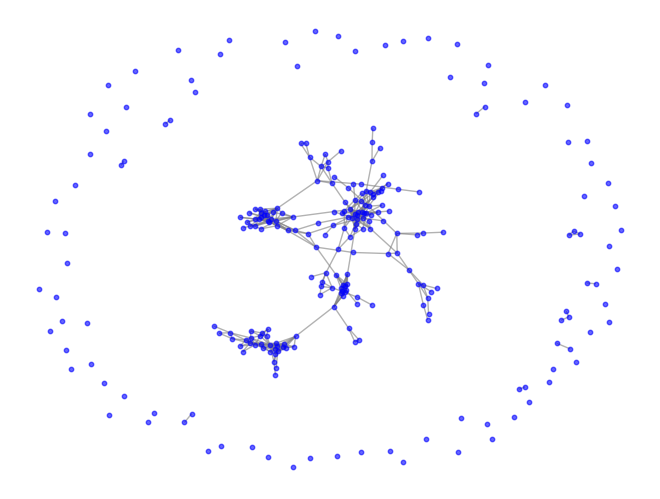

In [135]:
# draw network

nx.draw(corr_graph, with_labels=False, node_size=10, node_color='blue', edge_color='grey', alpha=0.6)